# Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data=pd.read_csv(r'/content/drive/My Drive/Sandy/emotion_fer2013/fer2013.csv')

# Data sampling and pre-processing

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
print('Samples distribution across Usage:')
print(data.Usage.value_counts())

Samples distribution across Usage:
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


In [6]:
print('Samples per emotion:')
print(data.emotion.value_counts())

Samples per emotion:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [7]:
print('Number of pixels for a sample:')
print(len(data.pixels[0].split(' ')))

Number of pixels for a sample:
2304


In [8]:
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

In [9]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [10]:
from math import sqrt

depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
df=data

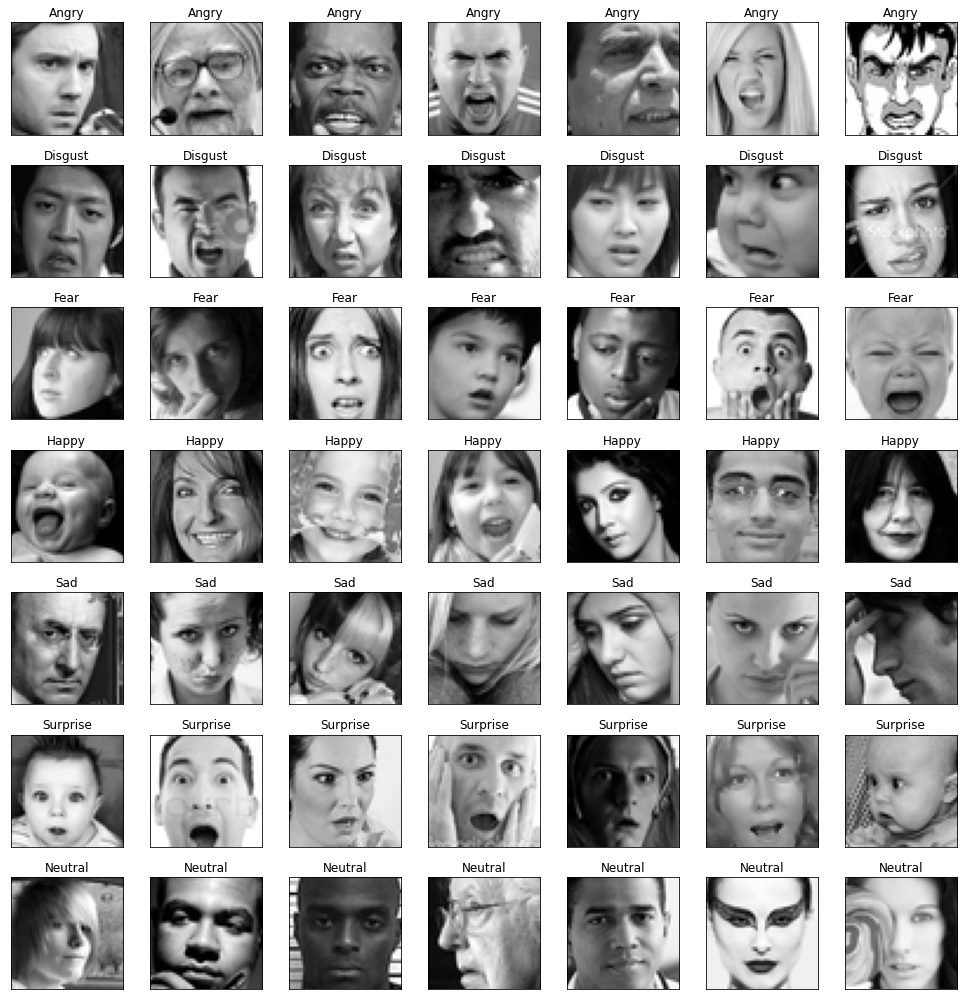

In [13]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        plt.tight_layout()

In [14]:
import cv2

In [15]:
def convert_fer2013(data):
    pixels = data['pixels'].tolist()

    faces = []
    for pixel_sq in pixels:
        face = [int(pixel) for pixel in pixel_sq.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (width, height))
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    emotions = pd.get_dummies(data['emotion']).values

    return faces, emotions

In [16]:
X_train, y_train = convert_fer2013(train_set)
X_validation,y_validation=convert_fer2013(validation_set)
X_test, y_test = convert_fer2013(test_set)



In [17]:
print('Training: ',X_train.shape)
print('Validation: ',X_validation.shape)
print('Test: ',X_test.shape)
print('Training: ',y_train.shape)
print('Validation: ',y_validation.shape)
print('Test: ',y_test.shape)

Training:  (28709, 48, 48, 3)
Validation:  (3589, 48, 48, 3)
Test:  (3589, 48, 48, 3)
Training:  (28709, 7)
Validation:  (3589, 7)
Test:  (3589, 7)


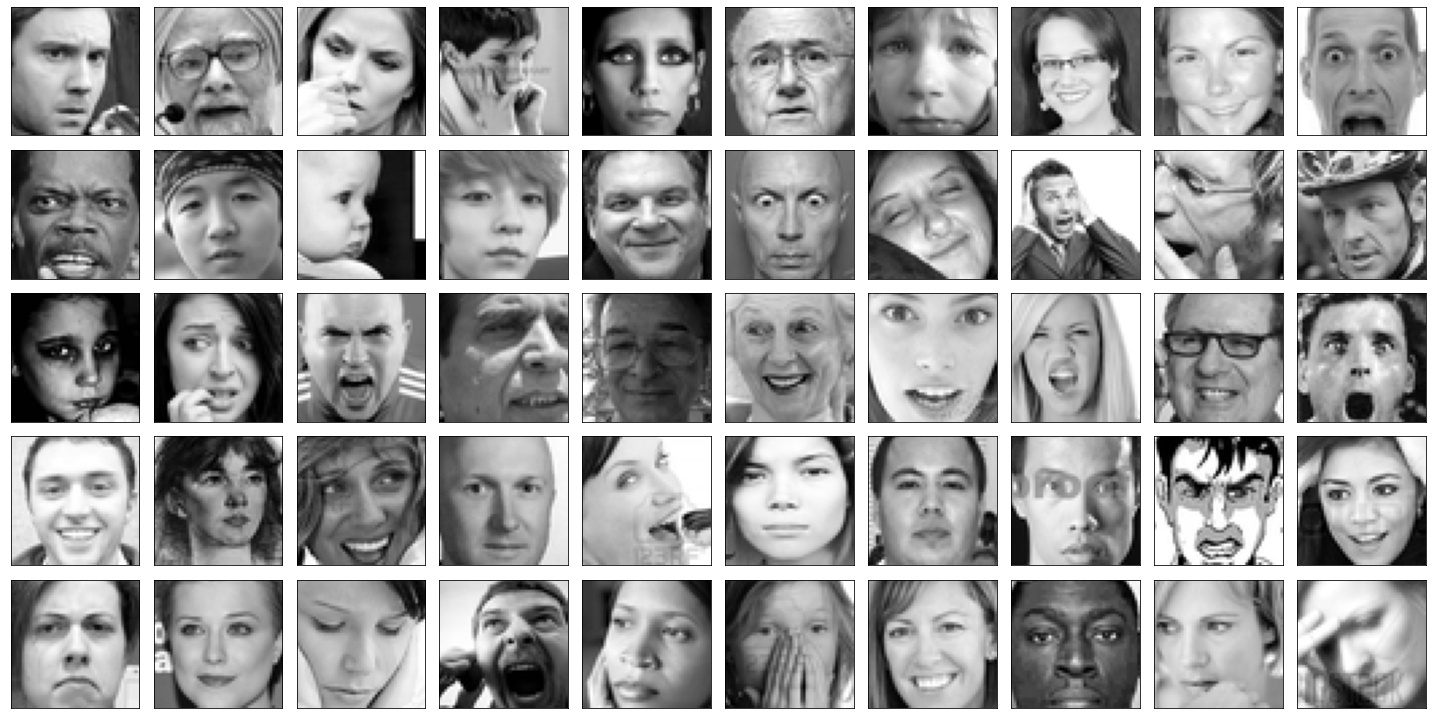

In [18]:
import matplotlib
import matplotlib.pyplot as plt

def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,50, X_train)

In [19]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 128

In [21]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_validation, y_validation, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

# Building the Network Architecture

# VGG16

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop ,Adadelta,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import pandas as pd


In [23]:
from tensorflow.keras.applications import VGG16
#Load the VGG model
vgg_in = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48,3))

def vgg_16():
    model = Sequential()
    #add vgg conv model
    model.add(vgg_in)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='normal'))
    #model.compile(loss='mean_squared_error', optimizer=adam())
    model.compile(loss='mean_squared_error', optimizer=RMSprop(),metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
    
    return model


58892288/58889256 [==============================] - 0s 0us/step


In [24]:
model_16 = vgg_16()
model_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 14,718,279
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [26]:
BS =128
EPOCHS = 50
len(X_train)

28709

In [27]:
history_16 = model_16.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / BS, 
                    epochs=EPOCHS,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_validation) / BS
                    ) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.11979, saving model to weights_min_loss.hdf5
225/224 - 28s - loss: 3328477440.0000 - accuracy: 0.2279 - val_loss: 0.1198 - val_accuracy: 0.2519
Epoch 2/50

Epoch 00002: val_loss improved from 0.11979 to 0.11672, saving model to weights_min_loss.hdf5
225/224 - 27s - loss: 0.1184 - accuracy: 0.2462 - val_loss: 0.1167 - val_accuracy: 0.2959
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.11672
225/224 - 27s - loss: 0.1218 - accuracy: 0.2339 - val_loss: 0.1187 - val_accuracy: 0.2494
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.11672
225/224 - 27s - loss: 0.4593 - accuracy: 0.2417 - val_loss: 0.1187 - val_accuracy: 0.2494
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.11672
225/224 - 27s - loss: 0.1204 - accuracy: 0.2482 - val_loss: 0.1183 - val_accuracy: 0.2494
Epoch 6/50

Epoch 00006: val_loss did not improve from 0.11672
225/2

In [28]:
# scores for Validation set
scores = model_16.evaluate(val_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 29ms/step - loss: 0.0734 - accuracy: 0.6336
Loss0.0734410509467125
Accuracy0.6336026787757874


In [33]:
# scores for test set
scores = model_16.evaluate(test_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 30ms/step - loss: 0.0731 - accuracy: 0.6350
Loss0.07308465242385864
Accuracy0.6349958181381226


<Figure size 432x288 with 0 Axes>

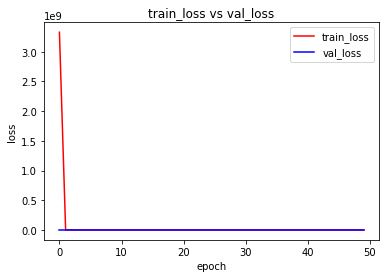

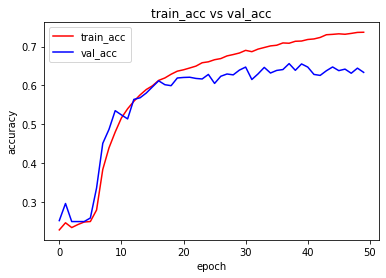

<Figure size 432x288 with 0 Axes>

In [59]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history_16.history['loss']
val_loss=history_16.history['val_loss']
train_acc=history_16.history['accuracy']
val_acc=history_16.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

#VGG19

In [34]:
from tensorflow.keras.applications import VGG19
#Load the VGG model
vgg_in19 = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48,3))
def vgg_19():
    model = Sequential()
    #add vgg conv model
    model.add(vgg_in19)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='normal'))
    #model.compile(loss='mean_squared_error', optimizer=adam())
    model.compile(loss='mean_squared_error', optimizer=RMSprop(),metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
    
    return model


80142336/80134624 [==============================] - 0s 0us/step


In [35]:
model19 = vgg_19()
model19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 20,027,975
Trainable params: 20,027,975
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss2.hdf5"
checkpoint2 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list2 = [checkpoint2]

In [53]:
BS =128
EPOCHS = 10
len(X_train)

28709

In [54]:
history2 = model19.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / BS, 
                    epochs=EPOCHS,  
                    verbose=2,  
                    callbacks=callbacks_list2,
                    validation_data=val_flow,  
                    validation_steps=len(X_validation) / BS) 

Epoch 1/10

Epoch 00001: val_loss did not improve from 0.11700
225/224 - 30s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1182 - val_accuracy: 0.2494
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.11700
225/224 - 29s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1181 - val_accuracy: 0.2494
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.11700
225/224 - 29s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1182 - val_accuracy: 0.2494
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.11700
225/224 - 29s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1181 - val_accuracy: 0.2494
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.11700
225/224 - 29s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1182 - val_accuracy: 0.2494
Epoch 6/10

Epoch 00006: val_loss did not improve from 0.11700
225/224 - 29s - loss: 0.1181 - accuracy: 0.2513 - val_loss: 0.1181 - val_accuracy: 0.2494
Epoch 7/10

Epoch 00007: val_loss did not improve from 0.11700
225/224 - 29s - los

In [55]:
#scores for Validation test
scores = model19.evaluate(val_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 36ms/step - loss: 0.1181 - accuracy: 0.2494
Loss0.1181027814745903
Accuracy0.24937307834625244


In [56]:
#scores for  test set
scores = model19.evaluate(test_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 34ms/step - loss: 0.1183 - accuracy: 0.2449
Loss0.11833442747592926
Accuracy0.24491502344608307


<Figure size 432x288 with 0 Axes>

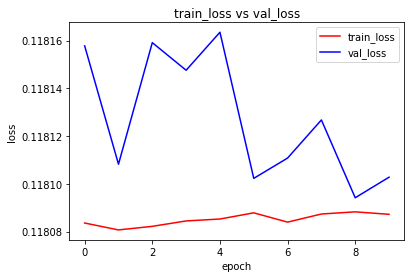

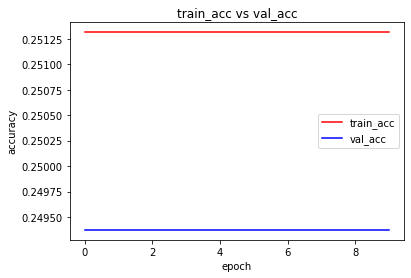

<Figure size 432x288 with 0 Axes>

In [58]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history2.history['loss']
val_loss=history2.history['val_loss']
train_acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

# Resnet50

In [42]:

from keras.applications.resnet50 import ResNet50
#Load the Resnet50 model
res_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48,3))

def Resnet50_custom():
    model = Sequential()
    #add Reset conv model
    model.add(res_conv)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='normal'))
    #model.compile(loss='mean_squared_error', optimizer=adam())
    model.compile(loss='mean_squared_error', optimizer=RMSprop(),metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
    
    return model


94773248/94765736 [==============================] - 1s 0us/step


In [43]:
model_Res = Resnet50_custom()
model_Res.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 57351     
Total params: 23,645,063
Trainable params: 23,591,943
Non-trainable params: 53,120
_________________________________________________________________


In [63]:
BS =128
EPOCHS = 75

len(X_train)

28709

In [64]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss3.hdf5"
checkpoint3 = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list3 = [checkpoint2]

In [65]:
history_3 = model_Res.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / BS, 
                    epochs=EPOCHS,  
                    verbose=2,  
                    callbacks=callbacks_list3,
                    validation_data=val_flow,  
                    validation_steps=len(X_validation) / BS) 

Epoch 1/75

Epoch 00001: val_loss improved from 0.11700 to 0.08445, saving model to weights_min_loss2.hdf5
225/224 - 29s - loss: 0.0520 - accuracy: 0.7430 - val_loss: 0.0845 - val_accuracy: 0.5801
Epoch 2/75

Epoch 00002: val_loss improved from 0.08445 to 0.08275, saving model to weights_min_loss2.hdf5
225/224 - 29s - loss: 0.0514 - accuracy: 0.7461 - val_loss: 0.0828 - val_accuracy: 0.5779
Epoch 3/75

Epoch 00003: val_loss did not improve from 0.08275
225/224 - 29s - loss: 0.0513 - accuracy: 0.7481 - val_loss: 0.0854 - val_accuracy: 0.5974
Epoch 4/75

Epoch 00004: val_loss improved from 0.08275 to 0.08273, saving model to weights_min_loss2.hdf5
225/224 - 29s - loss: 0.0503 - accuracy: 0.7524 - val_loss: 0.0827 - val_accuracy: 0.5924
Epoch 5/75

Epoch 00005: val_loss did not improve from 0.08273
225/224 - 29s - loss: 0.0500 - accuracy: 0.7535 - val_loss: 0.1063 - val_accuracy: 0.5127
Epoch 6/75

Epoch 00006: val_loss improved from 0.08273 to 0.07512, saving model to weights_min_loss2.h

In [66]:
#scores for Validation test
scores = model_Res.evaluate(val_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 31ms/step - loss: 0.1012 - accuracy: 0.5670
Loss0.10118498653173447
Accuracy0.5670102834701538


In [67]:
#scores for test set

scores = model_Res.evaluate(test_flow)

print("Loss"+ str(scores[0]))
print("Accuracy"+ str(scores[1]))

29/29 [==============================] - 1s 30ms/step - loss: 0.0966 - accuracy: 0.5818
Loss0.09655866026878357
Accuracy0.5817776322364807


<Figure size 432x288 with 0 Axes>

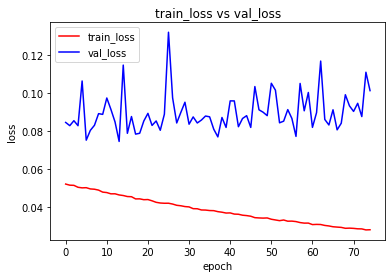

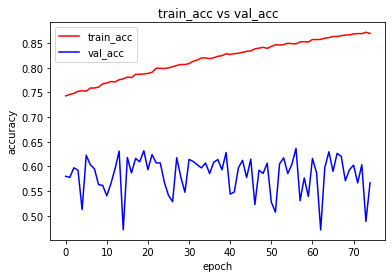

<Figure size 432x288 with 0 Axes>

In [68]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history_3.history['loss']
val_loss=history_3.history['val_loss']
train_acc=history_3.history['accuracy']
val_acc=history_3.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

## Conclusion

The accuracy acheived by VGG16 is 63% where as  Resnet approach is 58% where as VGG19 models is 24%